# Thin plate Spline Spatial Transformer Network

## Imports

In [1]:
import argparse
import logging
import time
from pathlib import PurePath
import itertools
# select GPU on the server
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'
# pytorch related package 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models

print('pytorch version: ' + torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# math and showcase
import matplotlib.pyplot as plt
import numpy as np

pytorch version: 1.8.1+cu111


In [2]:
# stub for argparse
class opts:
    def __init__(self):
        self.resume = False
        self.sess = 'small'
        self.seed = 37434461
        self.batch_size = 64
        self.epochs = 20
        self.n_grid_density = 5
        self.image_size = 28
        self.data_directory = './mnist_dis'
        self.output_directory = './mnist_stn'

args = opts()

## Models
follower: neural network of the original task. For now a simple small convolution neural network.

In [3]:
# class follower(nn.Module):
#     def __init__(self, args):
#         super(follower, self).__init__()
#         self.model = models.resnet18(num_classes=10)
#         self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

#     def forward(self, x):
#         x = self.model(x)
#         return x

class follower(nn.Module):
    def __init__(self, args):
        super(follower, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

localizer, part of the STN, train on data and output the distortion kernel for TPS

In [4]:
class localizer(nn.Module):
    def __init__(self, args, source_points):
        super(localizer, self).__init__()
        self.args = args
        n_output = args.n_grid_density**2 *2
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, n_output)
        # insert control point as bias
        bias = torch.flatten(source_points)
        self.fc2.bias.data.copy_(bias)
        self.fc2.weight.data.zero_()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        # x = torch.tanh(x) # bounded
        return x.view(self.args.batch_size, -1, 2)

class affine_localizer(nn.Module):
    def __init__(self, args):
        super(affine_localizer, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 6)
        # Initialize the weights/bias with identity transformation
        self.fc2.bias.data.copy_(torch.tensor([0.5, 0, 0, 0, 0.5, 0], dtype=torch.float).to(device))
        self.fc2.weight.data.zero_()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

tps_warper, a function that warp the image by distortion kernel

In [5]:
class tps_warper(nn.Module):
    def __init__(self, args, target_control_points):
        super(tps_warper, self).__init__()
        self.args = args
        self.target_control_points = target_control_points
        N = target_control_points.size(0)
        # create padded kernel matrix
        forward_kernel = torch.zeros(N + 3, N + 3)
        target_control_partial_repr = self.compute_partial_repr(target_control_points, target_control_points)
        forward_kernel[:N, :N].copy_(target_control_partial_repr)
        forward_kernel[:N, -3].fill_(1)
        forward_kernel[-3, :N].fill_(1)
        forward_kernel[:N, -2:].copy_(target_control_points)
        forward_kernel[-2:, :N].copy_(target_control_points.transpose(0, 1))
        # compute inverse matrix
        inverse_kernel = torch.inverse(forward_kernel)
        # create target cordinate matrix
        HW = self.args.image_size * self.args.image_size
        target_coordinate = list(itertools.product(range(self.args.image_size), range(self.args.image_size)))
        target_coordinate = torch.Tensor(target_coordinate).to(device) # HW x 2
        Y, X = target_coordinate.split(1, dim = 1)
        Y = Y * 2 / (self.args.image_size - 1) - 1
        X = X * 2 / (self.args.image_size - 1) - 1
        target_coordinate = torch.cat([X, Y], dim = 1) # convert from (y, x) to (x, y)
        target_coordinate_partial_repr = self.compute_partial_repr(target_coordinate, target_control_points)
        target_coordinate_repr = torch.cat([
            target_coordinate_partial_repr, torch.ones(HW, 1).to(device), target_coordinate
        ], dim = 1)
        # register precomputed matrices
        self.register_buffer('inverse_kernel', inverse_kernel)
        self.register_buffer('padding_matrix', torch.zeros(3, 2).expand(self.args.batch_size, 3, 2))
        self.register_buffer('target_coordinate_repr', target_coordinate_repr)

    def compute_partial_repr(self, input_points, control_points):
        N = input_points.size(0)
        M = control_points.size(0)
        pairwise_diff = input_points.view(N, 1, 2) - control_points.view(1, M, 2)
        # original implementation, very slow
        # pairwise_dist = torch.sum(pairwise_diff ** 2, dim = 2) # square of distance
        pairwise_diff_square = pairwise_diff * pairwise_diff
        pairwise_dist = pairwise_diff_square[:, :, 0] + pairwise_diff_square[:, :, 1]
        repr_matrix = 0.5 * pairwise_dist * torch.log(pairwise_dist)
        # fix numerical error for 0 * log(0), substitute all nan with 0
        mask = repr_matrix != repr_matrix
        repr_matrix.masked_fill_(mask, 0)
        return repr_matrix
    
    def forward(self, image, source_control_points):
        batch_size = source_control_points.size(0)
        Y = torch.cat([source_control_points, self.padding_matrix], 1)
        mapping_matrix = torch.matmul(self.inverse_kernel, Y)
        source_coordinate = torch.matmul(self.target_coordinate_repr, mapping_matrix)
        grid = source_coordinate.view(batch_size, self.args.image_size, self.args.image_size, 2)
        warped_image = F.grid_sample(image, grid, align_corners=True)
        return warped_image

class tps_warper(nn.Module):
    def __init__(self, args, source_points):
        super(tps_warper, self).__init__()
        self.args = args
        self.src_points = source_points
        
    def get_tensortype(self, tensor):
        return dict(dtype=tensor.dtype, device=tensor.device)
    
    def pair_square_euclidean(self, x1, x2):
        # ||x1 - x2||^2 = (x1-x2)^T(x1-x2) = x1^T*x1 + x2^T*x2 - 2*x1^T*x2
        x1_sq = x1.mul(x1).sum(dim=-1, keepdim=True)
        x2_sq = x2.mul(x2).sum(dim=-1, keepdim=True).transpose(1,2)
        x1_x2 = x1.matmul(x2.transpose(1,2))
        square_dist = -2 * x1_x2 + x1_sq + x2_sq
        square_dist = square_dist.clamp(min=0)  # handle possible numerical errors
        return square_dist
    def kernel_distance(self, r_sq, eps=1e-8):
        # Compute the TPS kernel distance function: r^2*log(r), where r is the euclidean distance
        return 0.5 * r_sq * r_sq.add(eps).log()
    
    def get_tps_parameters(self, source_points, dest_points):
        tensortype = self.get_tensortype(source_points)
        batch_size, n_points = source_points.shape[:2]
        # TPS warping has a close form equation:
        # find a_1, a_x, a_y, w_i in some equation (a surface for the warping)
        # to get coefficients (a_1, a_x, a_y, w_i), we need to solve a linear system
        # build matrix L
        pair_distance = self.pair_square_euclidean(source_points, dest_points)
        k_matrix = self.kernel_distance(pair_distance)
        dest_with_zeros = torch.cat((dest_points, torch.zeros(batch_size, 3, 2, **tensortype)), 1)
        p_matrix = torch.cat((torch.ones(batch_size, n_points, 1, **tensortype), source_points), -1)
        p_matrix_t = torch.cat((p_matrix, torch.zeros(batch_size, 3, 3, **tensortype)), 1).transpose(1,2)
        l_matrix = torch.cat((k_matrix, p_matrix), -1)
        l_matrix = torch.cat((l_matrix, p_matrix_t), 1)
        # solve the linear system
        weights, _ = torch.solve(dest_with_zeros, l_matrix)
        rbf_weights = weights[:, :-3]
        affine_weights = weights[:, -3:]
        # with these weights, we got a function for TPS warping
        return rbf_weights, affine_weights 
    
    def tps_warp_points(self, source_points, kernel_points, rbf_weights, affine_weights):
        # map all pixel to its new location
        pair_distance = self.pair_square_euclidean(source_points, kernel_points)
        k_matrix = self.kernel_distance(pair_distance)
        # rerpeat on x and y
        k_matrix = k_matrix.unsqueeze(3).repeat(1,1,1,2)
        source_points = source_points.unsqueeze(3).repeat(1,1,1,2)
        # add pixel dimension for broadcasting
        rbf_weights, affine_weights = rbf_weights.unsqueeze(1), affine_weights.unsqueeze(1)

        warped = k_matrix.mul(rbf_weights).sum(-2) + \
                 source_points.mul(affine_weights[:,:,1:,:]).sum(-2) + \
                 affine_weights[:,:,0,:]
        return warped
    
    def tps_warp_image(self, image, kernel_points, rbf_weights, affine_weights):
        tensortype = self.get_tensortype(kernel_points)
        batch_size, _, h, w = image.shape
        # create the grid to represent all the pixel
        ys, xs = torch.meshgrid(torch.linspace(-1, 1, h, **tensortype),
                                torch.linspace(-1, 1, w, **tensortype))
        coords = torch.stack([xs, ys], -1).view(-1, 2)
        coords = torch.stack([coords]*batch_size, 0)
        warped = self.tps_warp_points(coords, kernel_points, rbf_weights, affine_weights).view(-1, h, w, 2)
        warped_image = F.grid_sample(image, warped, align_corners=False)
        return warped_image

    def forward(self, image, dst_points):
        rbf_weights, affine_weights = self.get_tps_parameters(dst_points, self.src_points)
        warped_image = self.tps_warp_image(image, self.src_points, rbf_weights, affine_weights)
        return warped_image

In [6]:
class affine_warper(nn.Module):
    def __init__(self, args):
        super(affine_warper, self).__init__()
        self.args = args
    
    def forward(self, image, theta):
        grid = F.affine_grid(theta, image.size(), align_corners=False)
        warped_image = F.grid_sample(image, grid, align_corners=False)
        return warped_image
    

tps_stn, the structure of the whole tps-stn

In [7]:
class tps_stn(nn.Module):
    def __init__(self, args):
        super(tps_stn, self).__init__()
        self.args = args
        src_points = self.get_src_points(args.batch_size, args.n_grid_density).to(device)
        self.src_points = src_points.unsqueeze(0).repeat(args.batch_size, 1, 1)

        self.follower = follower(args)
        self.localizer = localizer(args, src_points)
        self.affine_localizer = affine_localizer(args)
        self.tps_warper = tps_warper(args, src_points)
        self.affine_warper = affine_warper(args)
        # self.tps_warper = tps_warper(args, self.src_points)

    # src_points create upon the n_grid_density is given
    def get_src_points(self, batch_size, n_grid_density=4, grid_span=0.9):
        src_points_1d = torch.linspace(-grid_span, grid_span, steps=n_grid_density)
        src_points_2d = torch.cartesian_prod(src_points_1d, src_points_1d)
        return src_points_2d
        
    def stn(self, x):
        kernel_points = self.localizer(x)
        theta = self.affine_localizer(x).view(-1, 2, 3)
        warped_x = self.tps_warper(x, kernel_points)
        # warped_x = self.affine_warper(warped_x, theta)
        return warped_x
        
    def forward(self, x):
        x = self.stn(x)
        x = self.follower(x)
        return x

In [8]:
# warrning: filename actually include the last dirname with it
class ImageFolderWithFilename(datasets.ImageFolder):
    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithFilename, self).__getitem__(index)
        path, _ = self.imgs[index]
        path_split = PurePath(path).parts
        filename = path_split[-2] + '/' +path_split[-1]
        new_tuple = (original_tuple + (filename,))
        return new_tuple

==> Preparing dataset..
==> Building model..

Epoch: 0000
==> Saving..

Epoch: 0001
==> Saving..

Epoch: 0002
==> Saving..

Epoch: 0003
==> Saving..

Epoch: 0004
==> Saving..

Epoch: 0005
==> Saving..

Epoch: 0006
==> Saving..

Epoch: 0007
==> Saving..

Epoch: 0008
==> Saving..

Epoch: 0009
==> Saving..

Epoch: 0010
==> Saving..

Epoch: 0011
==> Saving..

Epoch: 0012
==> Saving..

Epoch: 0013

Epoch: 0014
==> Saving..

Epoch: 0015

Epoch: 0016
==> Saving..

Epoch: 0017
==> Saving..

Epoch: 0018
==> Saving..

Epoch: 0019
==> Converting testing dataset using STN..
==> Done.


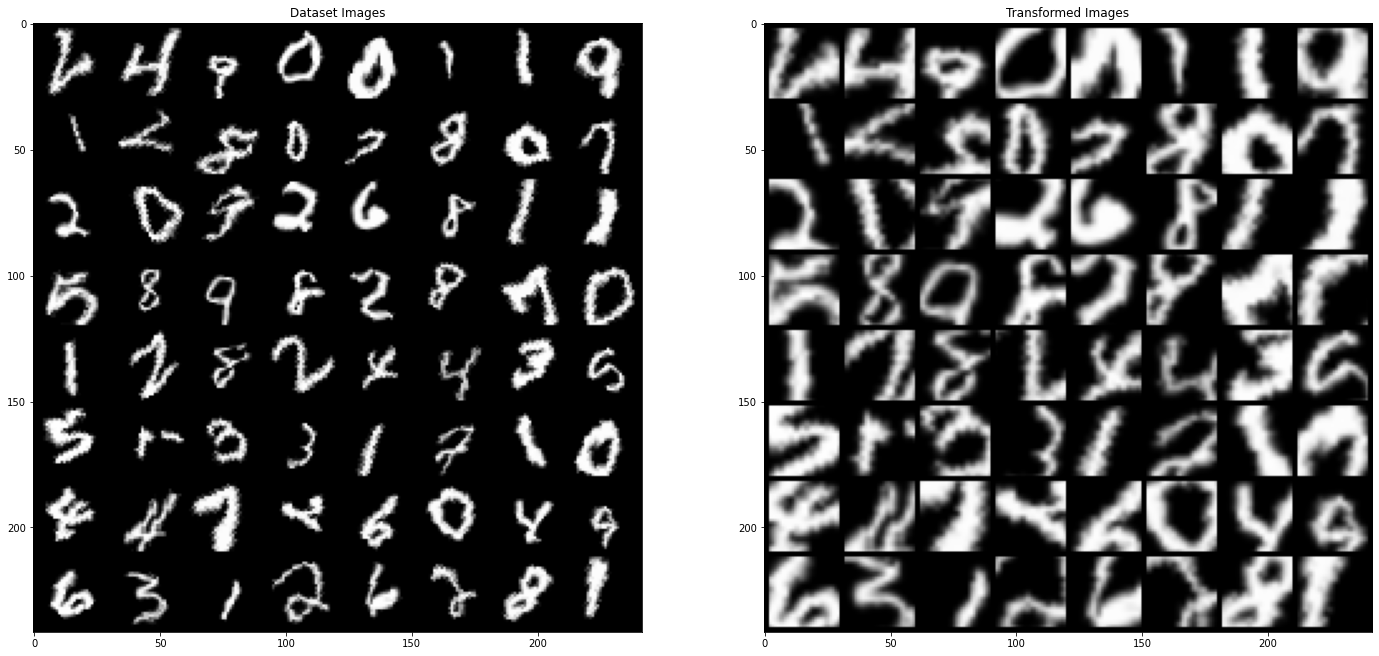

In [9]:
def main():
    args = opts() # TODO: replace it by argparse
    # Set seeds
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)

    print('==> Preparing dataset..')
    # Training dataset
    mean, std = (0.1307,), (0.3081,)
    train_transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        # transforms.RandomAffine(
            # degrees=15, # degree
            # shear=(-0.15, 0.15, -0.15, 0.15),
        # ),
        transforms.Normalize(mean, std), 
    ])
    test_transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    train_dataset = ImageFolderWithFilename(root=args.data_directory+'/training', \
        transform=train_transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size,\
        shuffle=True, drop_last=True, num_workers=8, pin_memory=True)
    test_dataset = ImageFolderWithFilename(root=args.data_directory+'/testing', \
        transform=test_transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size,\
        shuffle=True, drop_last=True, num_workers=8, pin_memory=True)

    # Load model
    if args.resume:
        # Load checkpoint.
        print('==> Resuming from checkpoint..')
        model = tps_stn(args).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        checkpoint = torch.load('./checkpoint/' + args.sess + '_' + str(args.seed) + '.pth')
        prev_acc = checkpoint['acc']
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_start = checkpoint['epoch'] + 1
        torch.set_rng_state(checkpoint['rng_state'])
    else:
        print('==> Building model..')
        epoch_start = 0
        prev_acc = 0.0
        model = tps_stn(args).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Logger
    result_folder = './results/'
    if not os.path.exists(result_folder):
        os.makedirs(result_folder)
    logger = logging.getLogger(__name__)
    logname = model.__class__.__name__ + '_' + args.sess + \
        '_' + str(args.seed) + '.log'
    logfile = os.path.join(result_folder, logname)
    if os.path.exists(logfile):
        os.remove(logfile)
    logging.basicConfig(
        format='[%(asctime)s] - %(message)s',
        datefmt='%Y/%m/%d %H:%M:%S',
        level=logging.INFO,
        filename=logfile
    )
    logger.info(args)

    # Training
    def train(epoch):
        print('\nEpoch: {:04}'.format(epoch))
        train_loss, correct, total = 0, 0, 0
        model.train()
        for batch_idx, (data, target, _) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output_logit = model(data)
            loss = F.cross_entropy(output_logit, target)
            loss.backward()
            optimizer.step()
            preds = F.softmax(output_logit, dim=1)
            preds_top_p, preds_top_class = preds.topk(1, dim=1)

            train_loss += loss.item() * target.size(0)
            total += target.size(0)
            correct += (preds_top_class.view(target.shape) == target).sum().item()

        return (train_loss / batch_idx, 100. * correct / total)
    # Test
    def test(epoch):
        model.eval()
        # load the best state_dict
        checkpoint = torch.load('./checkpoint/' + args.sess + '_' + str(args.seed) + '.pth')
        prev_acc = checkpoint['acc']
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        torch.set_rng_state(checkpoint['rng_state'])
        test_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for batch_idx, (data, target, _) in enumerate(test_loader):
                data, target = data.to(device), target.to(device)
    
                optimizer.zero_grad()
                output_logit = model(data)
                loss = F.cross_entropy(output_logit, target)
                preds = F.softmax(output_logit, dim=1)
                preds_top_p, preds_top_class = preds.topk(1, dim=1)
    
                test_loss += loss.item() * target.size(0)
                total += target.size(0)
                correct += (preds_top_class.view(target.shape) == target).sum().item()
        
        return (test_loss / batch_idx, 100. * correct / total)
    # Adjust testset using STN
    def convert():
        model.eval()
        # load the best state_dict
        checkpoint = torch.load('./checkpoint/' + args.sess + '_' + str(args.seed) + '.pth')
        prev_acc = checkpoint['acc']
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        torch.set_rng_state(checkpoint['rng_state'])
        # create folders
        testing_directory = args.output_directory + '/testing/'
        if not os.path.exists(testing_directory):
            os.makedirs(testing_directory)
        for classes in range(10):
            if not os.path.exists(testing_directory + str(classes)):
                os.makedirs(testing_directory + str(classes))
        print('==> Converting testing dataset using STN..')
        mean, std = (0.1307,), (0.3081,)
        inv_normalize = transforms.Normalize(
            mean= [-m/s for m, s in zip(mean, std)],
            std= [1/s for s in std]
        )
        with torch.no_grad():
            for batch_idx, (data, target, filename) in enumerate(test_loader):
                data, target = data.to(device), target.to(device)

                output_image = model.stn(data)
                output_image = inv_normalize(output_image)
                output_image = torch.clamp(output_image, 0, 1)
                
                for index, f in enumerate(filename):
                    image = output_image[index].detach().cpu()
                    f = testing_directory + f # it includes last dirname (same as target)
                    torchvision.utils.save_image(image, f)
    # visualize
    def visualize():
        model.eval()
        # load the best state_dict
        checkpoint = torch.load('./checkpoint/' + args.sess + '_' + str(args.seed) + '.pth')
        prev_acc = checkpoint['acc']
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        torch.set_rng_state(checkpoint['rng_state'])
        mean, std = (0.1307,), (0.3081,)
        inv_normalize = transforms.Normalize(
            mean= [-m/s for m, s in zip(mean, std)],
            std= [1/s for s in std]
        )
        with torch.no_grad():
            data = next(iter(test_loader))[0].to(device)
            input_image = inv_normalize(data)
            input_image = torch.clamp(input_image, 0, 1)
            output_image = model.stn(data)
            output_image = inv_normalize(output_image)
            output_image = torch.clamp(output_image, 0, 1)
            in_grid = torchvision.utils.make_grid(input_image.detach().cpu()).permute(1,2,0).numpy()
            out_grid = torchvision.utils.make_grid(output_image.detach().cpu()).permute(1,2,0).numpy()
            fig, axs = plt.subplots(1, 2, figsize=(24, 12))
            axs[0].imshow(in_grid)
            axs[0].set_title('Dataset Images')
            axs[1].imshow(out_grid)
            axs[1].set_title('Transformed Images')
            plt.show()
    # Save checkpoint
    def checkpoint(acc, epoch):
        print('==> Saving..')
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        save_path = './checkpoint/' + args.sess + '_' + str(args.seed) + '.pth'
        torch.save({
            'epoch': epoch,
            'acc': acc,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'rng_state': torch.get_rng_state(),
            }, save_path)
    
    # Run
    logger.info('Epoch \t Seconds \t \t Train Loss \t Train Acc')
    start_train_time = time.time()
    for epoch in range(epoch_start, args.epochs):
        start_epoch_time = time.time()
        
        train_loss, train_acc = train(epoch)
        epoch_time = time.time()
        logger.info('%5d \t %7.1f \t \t %10.4f \t %9.4f',
            epoch, epoch_time - start_epoch_time, train_loss, train_acc)
        # Save checkpoint.
        if train_acc - prev_acc  > 0.1:
            prev_acc = train_acc
            checkpoint(train_acc, epoch)
    train_time = time.time()
    logger.info('Total train time: %.4f minutes', (train_time - start_train_time)/60)

    # Evaluation
    logger.info('Test Loss \t Test Acc')
    test_loss, test_acc = test(epoch)
    logger.info('%9.4f \t %8.4f', test_loss, test_acc)

    # Converting testing dataset using STN..
    convert()
    print('==> Done.')
    
    visualize()

    
main()